BLOQUE 1: DESCARGA DE DATOS DE GAIA

Analizando el cúmulo: NGC 2516
Coordenadas: RA=119.5°, Dec=-60.75°
Radio de búsqueda: 1°

  Intentando autenticación en Gaia...
INFO: Login to gaia TAP server [astroquery.gaia.core]
INFO: OK [astroquery.utils.tap.core]
INFO: Login to gaia data server [astroquery.gaia.core]
INFO: OK [astroquery.utils.tap.core]
  ✓ Login exitoso en Gaia (queries ilimitadas)
\Downloading data from Gaia DR3...

 Running asynchronous query (may take 1-2 minutes)...
INFO: Query finished. [astroquery.utils.tap.core]
  Download complete (async): 22694 stars

Datos descargados exitosamente!
Número total de estrellas: 22694


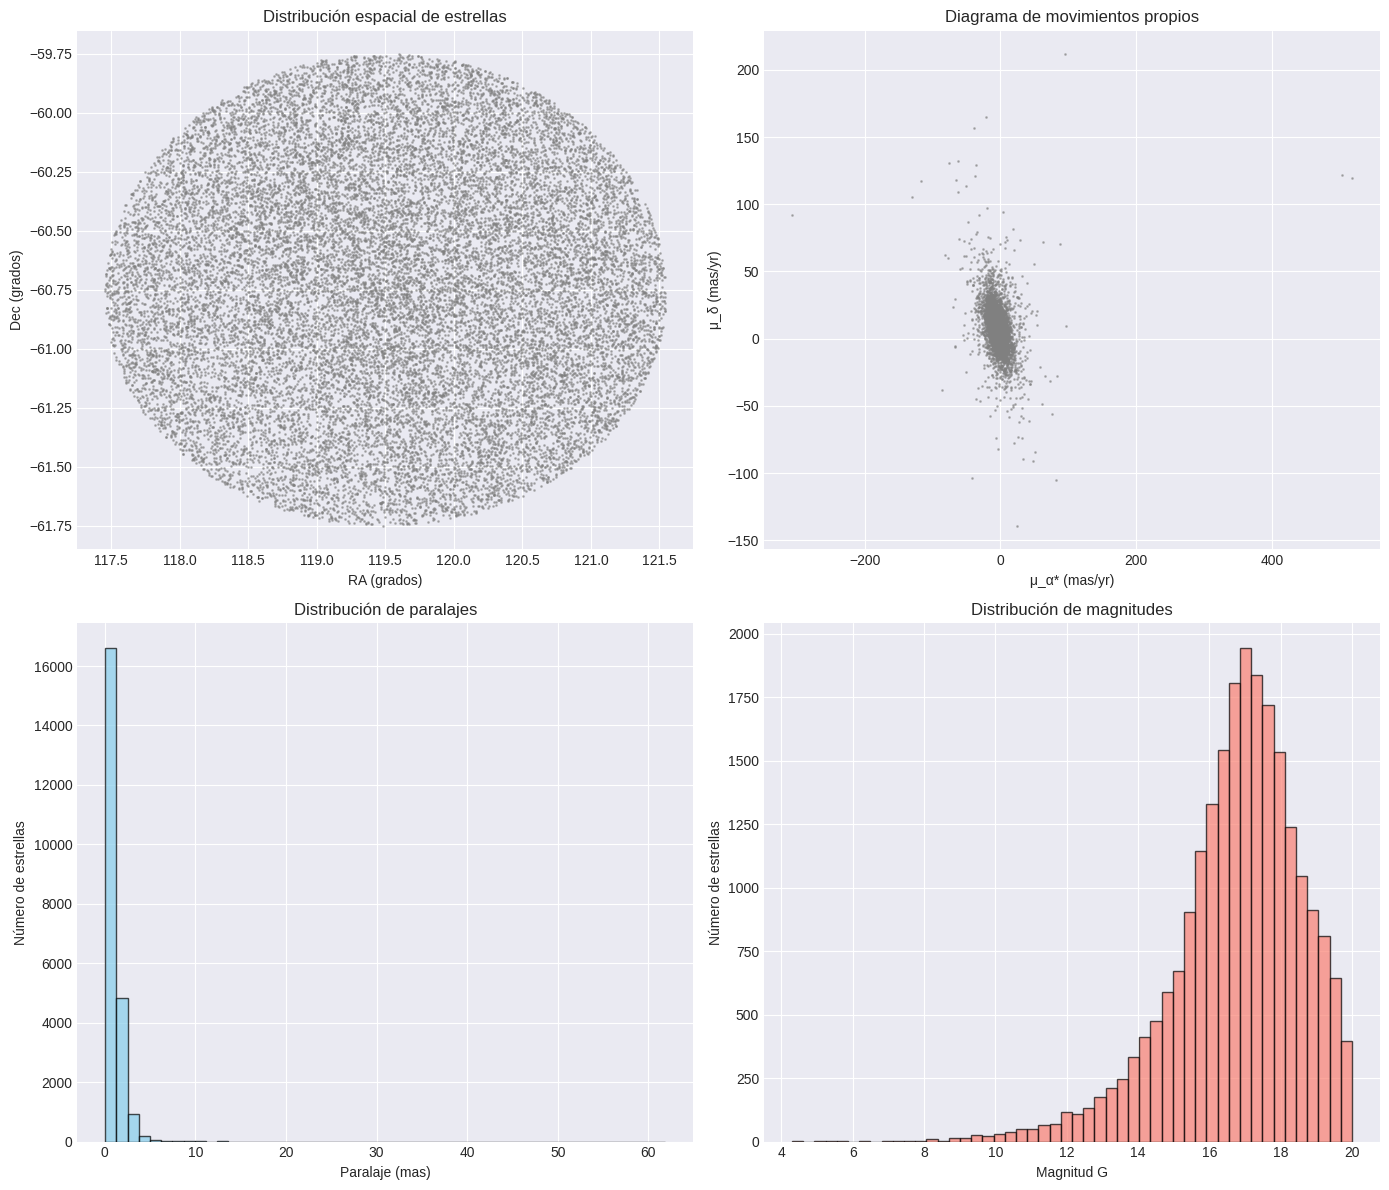


Estadísticas básicas de los datos:
  Paralaje medio: 1.09 ± 1.13 mas
  μ_α* medio: -3.72 ± 8.58 mas/yr
  μ_δ medio: 7.26 ± 9.52 mas/yr

BLOQUE 1.5: INSPECCIÓN VISUAL DEL ESPACIO DE PARÁMETROS

CRÍTICO: Antes de aplicar cualquier algoritmo, debemos MIRAR los datos.
¿Realmente hay un cúmulo visible? ¿Dónde está? ¿Qué tan separado está del campo?



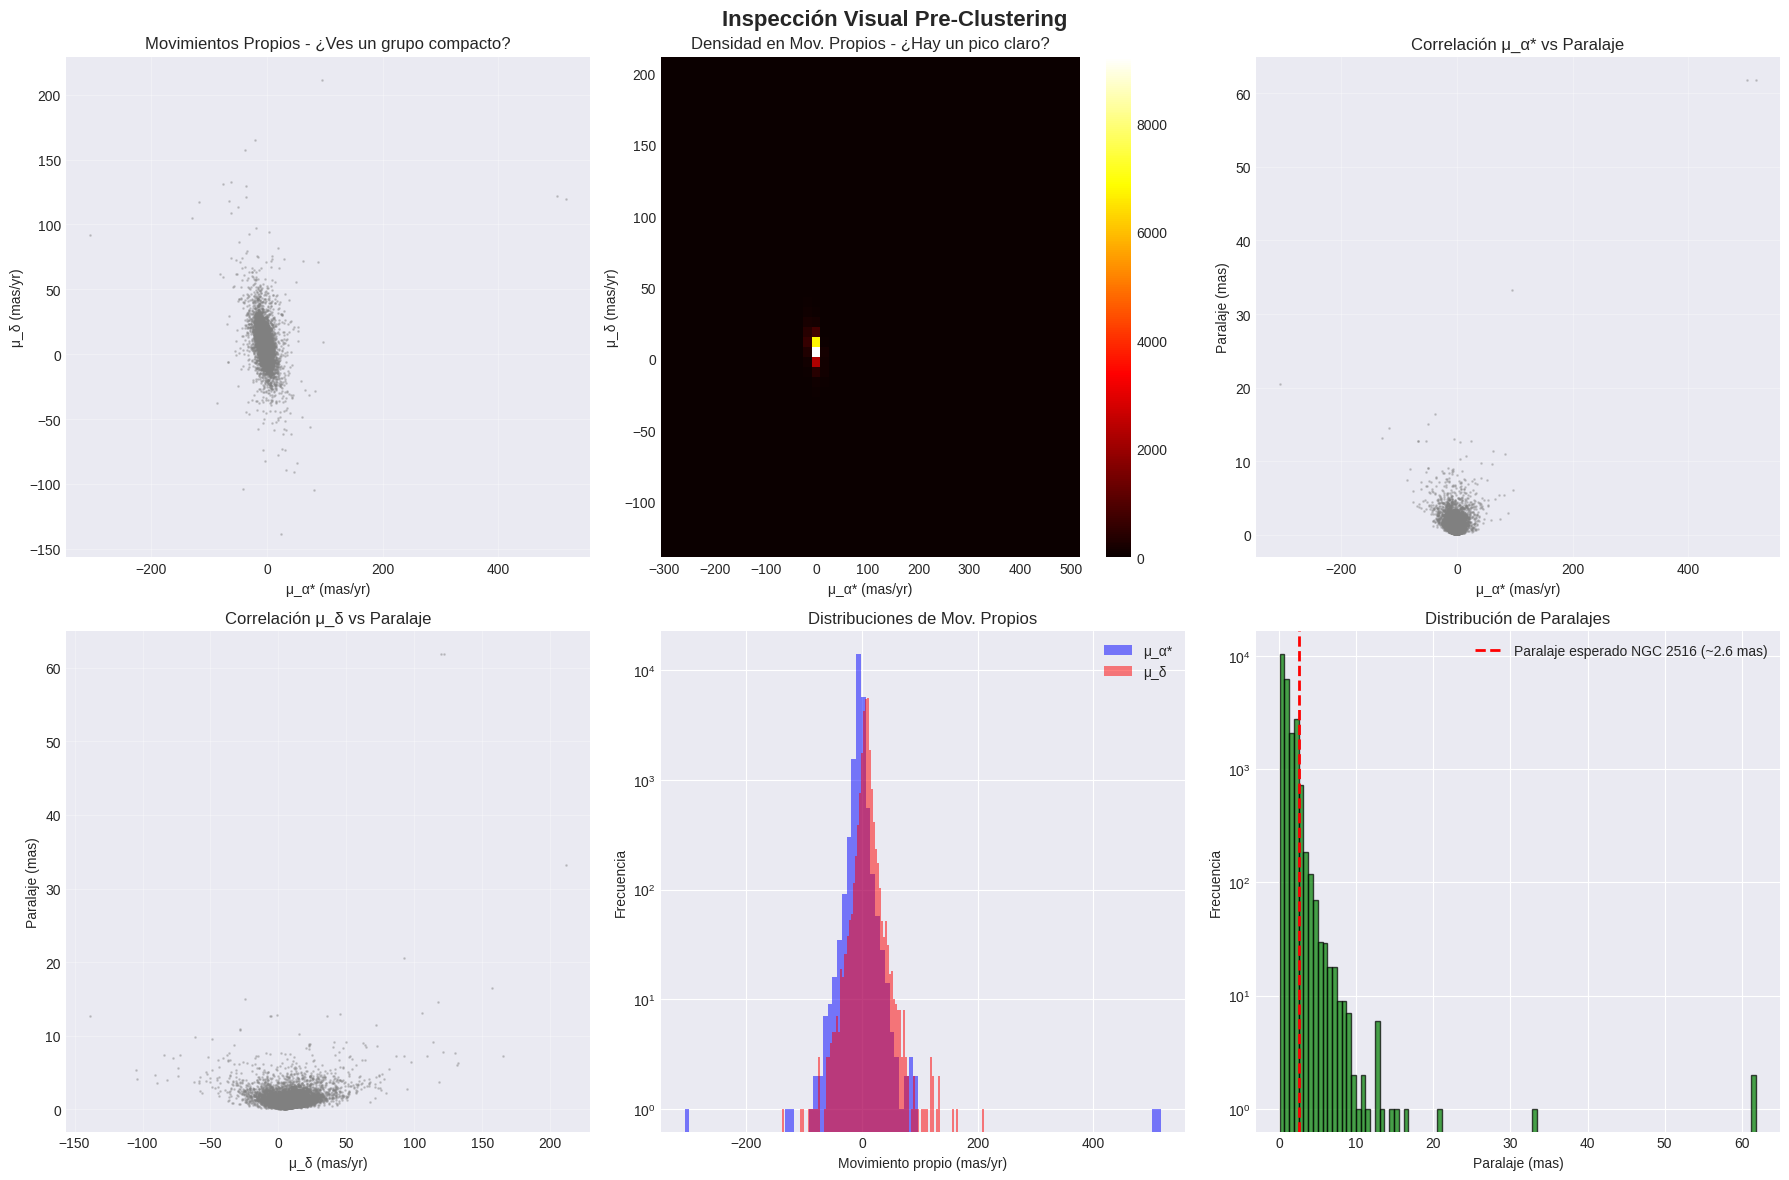


Estadísticas para NGC 2516 (literatura):
  Paralaje esperado: ~2.6 mas (distancia ~387 pc)
  μ_α* esperado: ~-4.5 mas/yr
  μ_δ esperado: ~+11 mas/yr

ESTRATEGIA DE PRE-FILTRADO:
Basándonos en la inspección visual y valores de literatura,
vamos a aplicar un filtro CONSERVADOR para reducir la contaminación:

Resultado del pre-filtrado:
  Estrellas antes: 22694
  Estrellas después: 2487
  Reducción: 89.0%

⚠️  ADVERTENCIA: Aún hay muchas estrellas.
    Considera estrechar los rangos de filtrado.


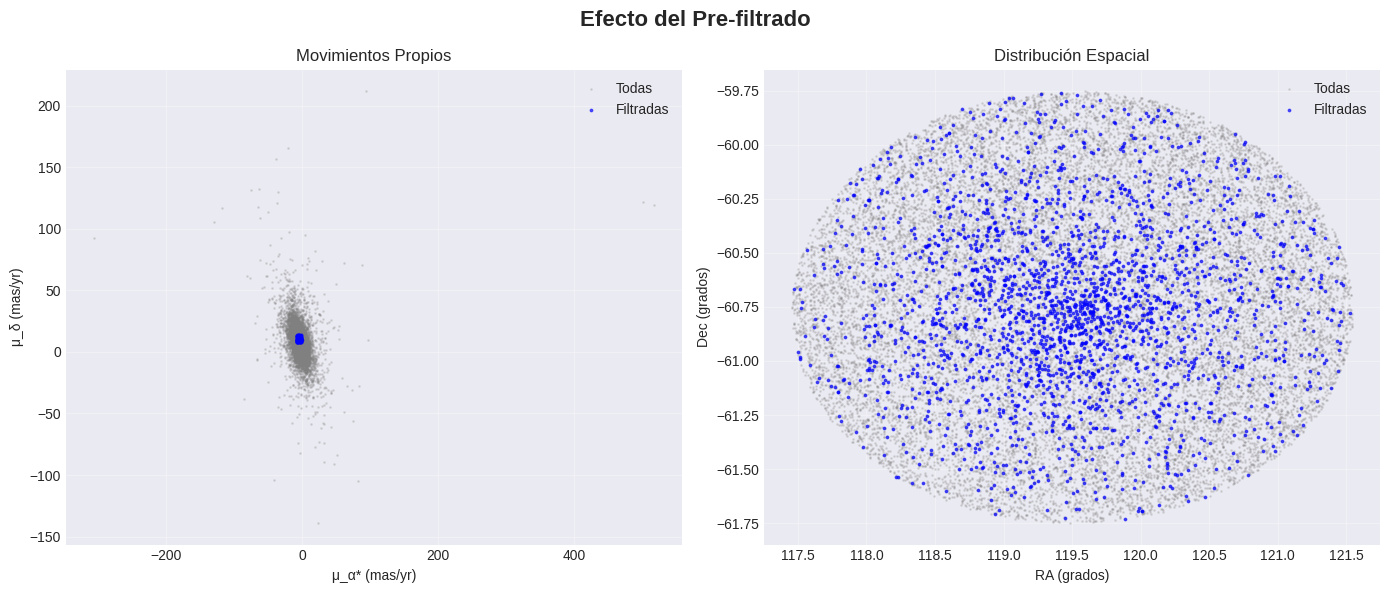


Procediendo con datos pre-filtrados para el clustering...


In [ ]:
# ================================================
# # Análisis de Pertenencia en Cúmulos Abiertos
# ================================================
# Este cuaderno ilustra diferentes métodos para determinar qué estrellas 
# pertenecen a un cúmulo abierto usando datos de Gaia

import numpy as np
import matplotlib.pyplot as plt
from astroquery.gaia import Gaia
from astropy.coordinates import SkyCoord
import astropy.units as u
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
import hdbscan
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 8)


# =============================================================================
# BLOQUE 1: DESCARGA DE DATOS DE GAIA
# =============================================================================

print("="*70)
print("BLOQUE 1: DESCARGA DE DATOS DE GAIA")
print("="*70)

# Parámetros del cúmulo a analizar
cluster_name = "NGC 2516"  # Puedes cambiar esto por cualquier otro cúmulo
cluster_ra = 119.5  # Ascensión recta en grados
cluster_dec = -60.75  # Declinación en grados
search_radius = 1 # Radio de búsqueda en grados

print(f"\nAnalizando el cúmulo: {cluster_name}")
print(f"Coordenadas: RA={cluster_ra}°, Dec={cluster_dec}°")
print(f"Radio de búsqueda: {search_radius}°")

# Construcción de la consulta ADQL (Astronomical Data Query Language)
# Esta consulta selecciona estrellas con buenos datos astrométricos
query = f"""
SELECT 
    ra, dec, pmra, pmdec, parallax,
    phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag,
    ruwe, astrometric_excess_noise
FROM gaiadr3.gaia_source
WHERE 1=CONTAINS(
    POINT('ICRS', ra, dec),
    CIRCLE('ICRS', {cluster_ra}, {cluster_dec}, {search_radius})
)
AND parallax IS NOT NULL
AND parallax/parallax_error > 5
AND pmra IS NOT NULL
AND pmdec IS NOT NULL
AND ruwe < 1.4
AND phot_g_mean_mag < 20
ORDER BY phot_g_mean_mag
"""
gaia_username="user"
gaia_password="pass"
authenticated = False

if gaia_username and gaia_password:
    try:
        print(f"\n  Intentando autenticación en Gaia...")
        Gaia.login(user=gaia_username, password=gaia_password)
        authenticated = True
        print("  ✓ Login exitoso en Gaia (queries ilimitadas)")
    except Exception as e:
        print(f"  ⚠ Login falló: {e}")
        print("  → Continuando sin autenticación (límite ~2000 filas)")


print("\Downloading data from Gaia DR3...")

try:
    if authenticated:
        # Asynchronous query
        print(f"\n Running asynchronous query (may take 1-2 minutes)...")
        job = Gaia.launch_job_async(query)
        data = job.get_results()
        print(f"  Download complete (async): {len(data)} stars")
    else:
        # Asynchronous query (anonymous, limited to 2000 rows)
        print(f"\n Running synchronous query...")
        job = Gaia.launch_job(query)
        data = job.get_results()
        print(f"  Download complete (sync): {len(data)} stars")
    
except Exception as e:
    print(f"\n Error executing query in Gaia: {e}")
    print("\nPossible causes:")
    print("  - Query too large (>2000 rows without authentication)")
    print("  - Server timeout")
    print("  - Incorrect ADQL syntax")
    raise

print(f"\nDatos descargados exitosamente!")
print(f"Número total de estrellas: {len(data)}")

# Convertir a arrays numpy para facilitar el análisis
ra = np.array(data['ra'])
dec = np.array(data['dec'])
pmra = np.array(data['pmra'])
pmdec = np.array(data['pmdec'])
parallax = np.array(data['parallax'])
gmag = np.array(data['phot_g_mean_mag'])

# Visualización inicial de los datos
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

axes[0, 0].scatter(ra, dec, s=1, alpha=0.5, c='gray')
axes[0, 0].set_xlabel('RA (grados)')
axes[0, 0].set_ylabel('Dec (grados)')
axes[0, 0].set_title('Distribución espacial de estrellas')

axes[0, 1].scatter(pmra, pmdec, s=1, alpha=0.5, c='gray')
axes[0, 1].set_xlabel('μ_α* (mas/yr)')
axes[0, 1].set_ylabel('μ_δ (mas/yr)')
axes[0, 1].set_title('Diagrama de movimientos propios')

axes[1, 0].hist(parallax, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[1, 0].set_xlabel('Paralaje (mas)')
axes[1, 0].set_ylabel('Número de estrellas')
axes[1, 0].set_title('Distribución de paralajes')

axes[1, 1].hist(gmag, bins=50, alpha=0.7, color='salmon', edgecolor='black')
axes[1, 1].set_xlabel('Magnitud G')
axes[1, 1].set_ylabel('Número de estrellas')
axes[1, 1].set_title('Distribución de magnitudes')

plt.tight_layout()
plt.savefig('datos_iniciales.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nEstadísticas básicas de los datos:")
print(f"  Paralaje medio: {np.mean(parallax):.2f} ± {np.std(parallax):.2f} mas")
print(f"  μ_α* medio: {np.mean(pmra):.2f} ± {np.std(pmra):.2f} mas/yr")
print(f"  μ_δ medio: {np.mean(pmdec):.2f} ± {np.std(pmdec):.2f} mas/yr")


# =============================================================================
# BLOQUE 1.5: INSPECCIÓN VISUAL Y PRE-FILTRADO
# =============================================================================

print("\n" + "="*70)
print("BLOQUE 1.5: INSPECCIÓN VISUAL DEL ESPACIO DE PARÁMETROS")
print("="*70)

print("""
CRÍTICO: Antes de aplicar cualquier algoritmo, debemos MIRAR los datos.
¿Realmente hay un cúmulo visible? ¿Dónde está? ¿Qué tan separado está del campo?
""")

# Crear visualización exploratoria detallada
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Inspección Visual Pre-Clustering', fontsize=16, fontweight='bold')

# 1. Movimientos propios - LA GRÁFICA CLAVE
axes[0, 0].scatter(pmra, pmdec, s=1, alpha=0.3, c='gray')
axes[0, 0].set_xlabel('μ_α* (mas/yr)')
axes[0, 0].set_ylabel('μ_δ (mas/yr)')
axes[0, 0].set_title('Movimientos Propios - ¿Ves un grupo compacto?')
axes[0, 0].grid(True, alpha=0.3)

# 2. Histograma 2D de movimientos propios (mapa de densidad)
h = axes[0, 1].hist2d(pmra, pmdec, bins=50, cmap='hot')
axes[0, 1].set_xlabel('μ_α* (mas/yr)')
axes[0, 1].set_ylabel('μ_δ (mas/yr)')
axes[0, 1].set_title('Densidad en Mov. Propios - ¿Hay un pico claro?')
plt.colorbar(h[3], ax=axes[0, 1])

# 3. Paralaje vs pmra
axes[0, 2].scatter(pmra, parallax, s=1, alpha=0.3, c='gray')
axes[0, 2].set_xlabel('μ_α* (mas/yr)')
axes[0, 2].set_ylabel('Paralaje (mas)')
axes[0, 2].set_title('Correlación μ_α* vs Paralaje')
axes[0, 2].grid(True, alpha=0.3)

# 4. Paralaje vs pmdec
axes[1, 0].scatter(pmdec, parallax, s=1, alpha=0.3, c='gray')
axes[1, 0].set_xlabel('μ_δ (mas/yr)')
axes[1, 0].set_ylabel('Paralaje (mas)')
axes[1, 0].set_title('Correlación μ_δ vs Paralaje')
axes[1, 0].grid(True, alpha=0.3)

# 5. Histogramas de cada parámetro
axes[1, 1].hist(pmra, bins=100, alpha=0.5, label='μ_α*', color='blue')
axes[1, 1].hist(pmdec, bins=100, alpha=0.5, label='μ_δ', color='red')
axes[1, 1].set_xlabel('Movimiento propio (mas/yr)')
axes[1, 1].set_ylabel('Frecuencia')
axes[1, 1].set_title('Distribuciones de Mov. Propios')
axes[1, 1].legend()
axes[1, 1].set_yscale('log')

# 6. Distribución de paralaje
axes[1, 2].hist(parallax, bins=100, alpha=0.7, color='green', edgecolor='black')
axes[1, 2].set_xlabel('Paralaje (mas)')
axes[1, 2].set_ylabel('Frecuencia')
axes[1, 2].set_title('Distribución de Paralajes')
axes[1, 2].axvline(2.6, color='red', linestyle='--', linewidth=2, 
                   label='Paralaje esperado NGC 2516 (~2.6 mas)')
axes[1, 2].legend()
axes[1, 2].set_yscale('log')

plt.tight_layout()
plt.savefig('inspeccion_visual_pre_clustering.png', dpi=150, bbox_inches='tight')
plt.show()

# Estadísticas para identificar el rango probable del cúmulo
print("\nEstadísticas para NGC 2516 (literatura):")
print("  Paralaje esperado: ~2.6 mas (distancia ~387 pc)")
print("  μ_α* esperado: ~-4.5 mas/yr")
print("  μ_δ esperado: ~+11 mas/yr")

print("\nESTRATEGIA DE PRE-FILTRADO:")
print("Basándonos en la inspección visual y valores de literatura,")
print("vamos a aplicar un filtro CONSERVADOR para reducir la contaminación:")

# Filtro basado en rangos esperados de NGC 2516
# Estos valores puedes ajustarlos según lo que veas en los gráficos
parallax_min, parallax_max = 1.5, 4.0  # mas
pmra_min, pmra_max = -8.0, -1.0  # mas/yr
pmdec_min, pmdec_max = 8.0, 14.0  # mas/yr

mask_prefilter = (
    (parallax >= parallax_min) & (parallax <= parallax_max) &
    (pmra >= pmra_min) & (pmra <= pmra_max) &
    (pmdec >= pmdec_min) & (pmdec <= pmdec_max)
)

n_before = len(data)
n_after = np.sum(mask_prefilter)
print(f"\nResultado del pre-filtrado:")
print(f"  Estrellas antes: {n_before}")
print(f"  Estrellas después: {n_after}")
print(f"  Reducción: {100*(1-n_after/n_before):.1f}%")

if n_after < 50:
    print("\n⚠️  ADVERTENCIA: Muy pocas estrellas después del filtro.")
    print("    Considera ampliar los rangos de filtrado.")
elif n_after > 2000:
    print("\n⚠️  ADVERTENCIA: Aún hay muchas estrellas.")
    print("    Considera estrechar los rangos de filtrado.")
else:
    print("\n✓ Número razonable de estrellas para análisis de clustering.")

# Aplicar el filtro a los datos
ra_filt = ra[mask_prefilter]
dec_filt = dec[mask_prefilter]
pmra_filt = pmra[mask_prefilter]
pmdec_filt = pmdec[mask_prefilter]
parallax_filt = parallax[mask_prefilter]
gmag_filt = gmag[mask_prefilter]

# Visualizar el efecto del filtro
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Efecto del Pre-filtrado', fontsize=16, fontweight='bold')

axes[0].scatter(pmra, pmdec, s=1, alpha=0.2, c='gray', label='Todas')
axes[0].scatter(pmra_filt, pmdec_filt, s=3, alpha=0.6, c='blue', label='Filtradas')
axes[0].set_xlabel('μ_α* (mas/yr)')
axes[0].set_ylabel('μ_δ (mas/yr)')
axes[0].set_title('Movimientos Propios')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].scatter(ra, dec, s=1, alpha=0.2, c='gray', label='Todas')
axes[1].scatter(ra_filt, dec_filt, s=3, alpha=0.6, c='blue', label='Filtradas')
axes[1].set_xlabel('RA (grados)')
axes[1].set_ylabel('Dec (grados)')
axes[1].set_title('Distribución Espacial')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('efecto_prefiltrado.png', dpi=150, bbox_inches='tight')
plt.show()

# Ahora usaremos estos datos filtrados para el clustering
print("\n" + "="*70)
print("Procediendo con datos pre-filtrados para el clustering...")
print("="*70)



In [ ]:

# =============================================================================
# BLOQUE 2: ANÁLISIS DE PERTENENCIA CON DBSCAN (sobre datos filtrados)
# =============================================================================

print("\n" + "="*70)
print("BLOQUE 2: ANÁLISIS CON DBSCAN")
print("="*70)

print("""
DBSCAN (Density-Based Spatial Clustering of Applications with Noise) es un 
algoritmo que agrupa puntos basándose en su densidad local. Imagina que estás
buscando manchas de pintura en una pared: DBSCAN identifica regiones donde hay
muchos puntos cercanos entre sí (alta densidad) y las separa de regiones donde
los puntos están dispersos.

El algoritmo tiene dos parámetros principales:
- eps (epsilon): la distancia máxima entre dos puntos para considerarlos vecinos.
  Es como decir "dos personas están en el mismo grupo si están a menos de 2 metros".
- min_samples: el número mínimo de puntos necesarios para formar un grupo denso.
  Es como decir "necesitamos al menos 5 personas cerca para considerar que hay una reunión".

DBSCAN es especialmente bueno para cúmulos porque:
1. No asume que los grupos tienen forma esférica
2. Puede identificar puntos como "ruido" (estrellas del campo)
3. No necesita saber de antemano cuántos cúmulos hay
""")

# Preparar los datos FILTRADOS para clustering
# Usaremos movimientos propios y paralaje (el espacio más discriminante)
X_dbscan = np.column_stack([pmra_filt, pmdec_filt, parallax_filt])

# Normalizar los datos para que todas las dimensiones tengan peso similar
# Esto es crucial porque pmra, pmdec y parallax tienen escalas diferentes
scaler_dbscan = StandardScaler()
X_dbscan_scaled = scaler_dbscan.fit_transform(X_dbscan)

print("\nAplicando DBSCAN sobre datos filtrados...")
print("Parámetros ajustados: eps=0.3, min_samples=10")
print("(eps más pequeño porque ahora los datos están más limpios)")

# Aplicar DBSCAN con parámetros ajustados
dbscan = DBSCAN(eps=0.3, min_samples=10)
labels_dbscan = dbscan.fit_predict(X_dbscan_scaled)

# Análisis de resultados
n_clusters_dbscan = len(set(labels_dbscan)) - (1 if -1 in labels_dbscan else 0)
n_noise_dbscan = list(labels_dbscan).count(-1)

print(f"\nResultados de DBSCAN:")
print(f"  Número de cúmulos identificados: {n_clusters_dbscan}")
print(f"  Estrellas clasificadas como ruido (campo): {n_noise_dbscan}")
print(f"  Estrellas en cúmulos: {len(pmra_filt) - n_noise_dbscan}")

# Asumimos que el cúmulo principal es el grupo más grande (excluyendo el ruido)
if n_clusters_dbscan > 0:
    cluster_sizes = [np.sum(labels_dbscan == i) for i in range(n_clusters_dbscan)]
    main_cluster_id = np.argmax(cluster_sizes)
    mask_members_dbscan = labels_dbscan == main_cluster_id
    print(f"  Cúmulo principal tiene {cluster_sizes[main_cluster_id]} estrellas")
else:
    mask_members_dbscan = np.zeros(len(pmra_filt), dtype=bool)

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Resultados del Análisis con DBSCAN', fontsize=16, fontweight='bold')

# Diagrama de movimientos propios
colors_dbscan = ['red' if x == -1 else 'blue' if x == main_cluster_id else 'green' 
                 for x in labels_dbscan]
axes[0, 0].scatter(pmra_filt, pmdec_filt, c=colors_dbscan, s=2, alpha=0.6)
axes[0, 0].set_xlabel('μ_α* (mas/yr)')
axes[0, 0].set_ylabel('μ_δ (mas/yr)')
axes[0, 0].set_title('Movimientos propios (azul=cúmulo, rojo=campo)')

# Distribución espacial
axes[0, 1].scatter(ra_filt, dec_filt, c=colors_dbscan, s=2, alpha=0.6)
axes[0, 1].set_xlabel('RA (grados)')
axes[0, 1].set_ylabel('Dec (grados)')
axes[0, 1].set_title('Distribución espacial')

# Paralaje vs magnitud
axes[1, 0].scatter(parallax_filt, gmag_filt, c=colors_dbscan, s=2, alpha=0.6)
axes[1, 0].set_xlabel('Paralaje (mas)')
axes[1, 0].set_ylabel('Magnitud G')
axes[1, 0].invert_yaxis()
axes[1, 0].set_title('Diagrama paralaje-magnitud')

# Histograma de paralajes
axes[1, 1].hist(parallax_filt[labels_dbscan == -1], bins=30, alpha=0.5, 
                label='Campo', color='red', edgecolor='black')
if np.sum(mask_members_dbscan) > 0:
    axes[1, 1].hist(parallax_filt[mask_members_dbscan], bins=30, alpha=0.5, 
                    label='Cúmulo', color='blue', edgecolor='black')
axes[1, 1].set_xlabel('Paralaje (mas)')
axes[1, 1].set_ylabel('Número de estrellas')
axes[1, 1].set_title('Comparación de paralajes')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('resultados_dbscan.png', dpi=150, bbox_inches='tight')
plt.show()


# =============================================================================
# BLOQUE 3: ANÁLISIS DE PERTENENCIA CON HDBSCAN
# =============================================================================

print("\n" + "="*70)
print("BLOQUE 3: ANÁLISIS CON HDBSCAN")
print("="*70)

print("""
HDBSCAN (Hierarchical DBSCAN) es una evolución de DBSCAN que resuelve uno de sus
principales problemas: DBSCAN asume que la densidad es uniforme en todo el espacio,
pero en astrofísica esto rara vez es cierto. Un cúmulo puede tener un núcleo muy
denso y una corona más dispersa.

Para entender HDBSCAN, imagina que estás mirando una ciudad desde un avión. Si usas
DBSCAN con una distancia fija, podrías identificar bien el centro de la ciudad (muy
denso) pero perder los suburbios (menos densos), o viceversa. HDBSCAN es como tener
múltiples niveles de zoom: identifica estructuras densas a diferentes escalas y luego
decide cuál es la más "estable" o persistente.

HDBSCAN usa un parámetro principal:
- min_cluster_size: el tamaño mínimo de un grupo para considerarlo un cúmulo válido.

Ventajas de HDBSCAN para cúmulos abiertos:
1. Maneja variaciones de densidad dentro del cúmulo
2. Es más robusto frente a la elección de parámetros
3. Proporciona una medida de "probabilidad de pertenencia" para cada estrella
4. Detecta mejor estructuras jerárquicas (como sub-cúmulos)
""")

# Usar los mismos datos normalizados
X_hdbscan_scaled = X_dbscan_scaled.copy()

print("\nAplicando HDBSCAN sobre datos filtrados...")
print("Parámetros ajustados: min_cluster_size=10, min_samples=3")

# Aplicar HDBSCAN
hdb = hdbscan.HDBSCAN(min_cluster_size=15, min_samples=5)
labels_hdbscan = hdb.fit_predict(X_hdbscan_scaled)

# HDBSCAN proporciona probabilidades de pertenencia
probabilities_hdbscan = hdb.probabilities_

# Análisis de resultados
n_clusters_hdbscan = len(set(labels_hdbscan)) - (1 if -1 in labels_hdbscan else 0)
n_noise_hdbscan = list(labels_hdbscan).count(-1)

print(f"\nResultados de HDBSCAN:")
print(f"  Número de cúmulos identificados: {n_clusters_hdbscan}")
print(f"  Estrellas clasificadas como ruido (campo): {n_noise_hdbscan}")
print(f"  Estrellas en cúmulos: {len(pmra_filt) - n_noise_hdbscan}")

# Identificar el cúmulo principal
if n_clusters_hdbscan > 0:
    cluster_sizes_hdb = [np.sum(labels_hdbscan == i) for i in range(n_clusters_hdbscan)]
    main_cluster_id_hdb = np.argmax(cluster_sizes_hdb)
    mask_members_hdbscan = labels_hdbscan == main_cluster_id_hdb
    print(f"  Cúmulo principal tiene {cluster_sizes_hdb[main_cluster_id_hdb]} estrellas")
    print(f"  Probabilidad media de pertenencia: {np.mean(probabilities_hdbscan[mask_members_hdbscan]):.3f}")
else:
    mask_members_hdbscan = np.zeros(len(pmra_filt), dtype=bool)

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Resultados del Análisis con HDBSCAN', fontsize=16, fontweight='bold')

# Diagrama de movimientos propios con probabilidades
scatter = axes[0, 0].scatter(pmra_filt, pmdec_filt, c=probabilities_hdbscan, 
                             s=2, alpha=0.6, cmap='viridis')
axes[0, 0].set_xlabel('μ_α* (mas/yr)')
axes[0, 0].set_ylabel('μ_δ (mas/yr)')
axes[0, 0].set_title('Movimientos propios (color=probabilidad de pertenencia)')
plt.colorbar(scatter, ax=axes[0, 0], label='Probabilidad')

# Distribución espacial
colors_hdbscan = ['red' if x == -1 else 'blue' if x == main_cluster_id_hdb else 'green' 
                  for x in labels_hdbscan]
axes[0, 1].scatter(ra_filt, dec_filt, c=colors_hdbscan, s=2, alpha=0.6)
axes[0, 1].set_xlabel('RA (grados)')
axes[0, 1].set_ylabel('Dec (grados)')
axes[0, 1].set_title('Distribución espacial (azul=cúmulo, rojo=campo)')

# Histograma de probabilidades
axes[1, 0].hist(probabilities_hdbscan[mask_members_hdbscan], bins=30, 
                alpha=0.7, color='blue', edgecolor='black')
axes[1, 0].set_xlabel('Probabilidad de pertenencia')
axes[1, 0].set_ylabel('Número de estrellas')
axes[1, 0].set_title('Distribución de probabilidades (cúmulo principal)')
axes[1, 0].axvline(0.5, color='red', linestyle='--', label='Umbral típico')
axes[1, 0].legend()

# Comparación de densidades en espacio de movimientos propios
axes[1, 1].scatter(pmra_filt[labels_hdbscan == -1], pmdec_filt[labels_hdbscan == -1], 
                   s=1, alpha=0.3, color='red', label='Campo')
if np.sum(mask_members_hdbscan) > 0:
    axes[1, 1].scatter(pmra_filt[mask_members_hdbscan], pmdec_filt[mask_members_hdbscan], 
                       s=5, alpha=0.6, color='blue', label='Cúmulo')
axes[1, 1].set_xlabel('μ_α* (mas/yr)')
axes[1, 1].set_ylabel('μ_δ (mas/yr)')
axes[1, 1].set_title('Separación campo-cúmulo en mov. propios')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('resultados_hdbscan.png', dpi=150, bbox_inches='tight')
plt.show()


# =============================================================================
# BLOQUE 4: ANÁLISIS DE PERTENENCIA CON GMM
# =============================================================================

print("\n" + "="*70)
print("BLOQUE 4: ANÁLISIS CON GMM (Gaussian Mixture Models)")
print("="*70)

print("""
GMM (Gaussian Mixture Models) adopta un enfoque completamente diferente. En lugar de
buscar regiones densas, GMM asume que los datos provienen de una mezcla de distribuciones
gaussianas (normales). Es un enfoque probabilístico: cada estrella tiene una cierta
probabilidad de pertenecer a cada componente gaussiana.

Para entender GMM, piensa en medir las alturas de estudiantes en una escuela mixta.
Si graficas las alturas, verás dos "jorobas" superpuestas: una para niñas (gaussiana 1)
y otra para niños (gaussiana 2). GMM intenta identificar estas gaussianas subyacentes.

En el contexto de cúmulos abiertos:
- Una gaussiana representa las estrellas del cúmulo (centrada en el movimiento propio
  y paralaje característicos del cúmulo)
- Otras gaussianas pueden representar el campo o sub-poblaciones

Parámetros principales:
- n_components: número de gaussianas a ajustar (típicamente 2: cúmulo + campo)
- covariance_type: cómo modelar la forma de las gaussianas
  * 'full': cada gaussiana puede tener cualquier forma elipsoidal
  * 'tied': todas las gaussianas tienen la misma forma
  * 'diag': gaussianas con ejes alineados a las coordenadas
  * 'spherical': gaussianas circulares

Ventajas de GMM:
1. Proporciona probabilidades de pertenencia suaves (no binarias)
2. Tiene un fundamento estadístico sólido
3. Funciona bien cuando el cúmulo y el campo tienen distribuciones distintas

Desventajas:
1. Asume distribuciones gaussianas (que pueden no ser perfectas)
2. Sensible a la inicialización
3. Necesitas especificar el número de componentes
""")

# Preparar datos (usamos los mismos normalizados)
X_gmm_scaled = X_dbscan_scaled.copy()

print("\nAplicando GMM con 2 componentes sobre datos filtrados...")
print("Parámetros: n_components=2, covariance_type='full'")

# Aplicar GMM
gmm = GaussianMixture(n_components=2, covariance_type='full', 
                      n_init=10, random_state=42)
gmm.fit(X_gmm_scaled)

# Predecir etiquetas y probabilidades
labels_gmm = gmm.predict(X_gmm_scaled)
probabilities_gmm = gmm.predict_proba(X_gmm_scaled)

# Identificar qué componente es el cúmulo
# El cúmulo típicamente tiene paralajes más grandes (está más cerca) y es más compacto
mean_parallax_comp0 = np.mean(parallax_filt[labels_gmm == 0])
mean_parallax_comp1 = np.mean(parallax_filt[labels_gmm == 1])

# La componente con mayor paralaje medio probablemente sea el cúmulo
cluster_component = 0 if mean_parallax_comp0 > mean_parallax_comp1 else 1
mask_members_gmm = labels_gmm == cluster_component

# Probabilidad de pertenencia al cúmulo
prob_cluster_gmm = probabilities_gmm[:, cluster_component]

print(f"\nResultados de GMM:")
print(f"  Componente identificada como cúmulo: {cluster_component}")
print(f"  Estrellas asignadas al cúmulo: {np.sum(mask_members_gmm)}")
print(f"  Estrellas asignadas al campo: {np.sum(~mask_members_gmm)}")
print(f"  Paralaje medio del cúmulo: {mean_parallax_comp0 if cluster_component == 0 else mean_parallax_comp1:.2f} mas")
print(f"  Paralaje medio del campo: {mean_parallax_comp1 if cluster_component == 0 else mean_parallax_comp0:.2f} mas")

# Estadísticas de probabilidades
print(f"\nEstadísticas de probabilidades de pertenencia al cúmulo:")
print(f"  Media: {np.mean(prob_cluster_gmm[mask_members_gmm]):.3f}")
print(f"  Mediana: {np.median(prob_cluster_gmm[mask_members_gmm]):.3f}")
print(f"  Mínimo: {np.min(prob_cluster_gmm[mask_members_gmm]):.3f}")

# Visualización
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Resultados del Análisis con GMM', fontsize=16, fontweight='bold')

# Diagrama de movimientos propios con probabilidades
scatter = axes[0, 0].scatter(pmra_filt, pmdec_filt, c=prob_cluster_gmm, 
                             s=2, alpha=0.6, cmap='RdYlBu_r')
axes[0, 0].set_xlabel('μ_α* (mas/yr)')
axes[0, 0].set_ylabel('μ_δ (mas/yr)')
axes[0, 0].set_title('Movimientos propios (rojo=cúmulo, azul=campo)')
plt.colorbar(scatter, ax=axes[0, 0], label='P(cúmulo)')

# Distribución espacial
colors_gmm = ['blue' if m else 'red' for m in mask_members_gmm]
axes[0, 1].scatter(ra_filt, dec_filt, c=colors_gmm, s=2, alpha=0.6)
axes[0, 1].set_xlabel('RA (grados)')
axes[0, 1].set_ylabel('Dec (grados)')
axes[0, 1].set_title('Distribución espacial (azul=cúmulo, rojo=campo)')

# Histograma de probabilidades
axes[1, 0].hist(prob_cluster_gmm, bins=50, alpha=0.7, 
                color='purple', edgecolor='black')
axes[1, 0].set_xlabel('Probabilidad de pertenencia al cúmulo')
axes[1, 0].set_ylabel('Número de estrellas')
axes[1, 0].set_title('Distribución de probabilidades')
axes[1, 0].axvline(0.5, color='red', linestyle='--', label='Umbral 50%')
axes[1, 0].legend()

# Diagrama de paralaje-magnitud con colores por probabilidad
scatter2 = axes[1, 1].scatter(parallax_filt, gmag_filt, c=prob_cluster_gmm, 
                              s=2, alpha=0.6, cmap='RdYlBu_r')
axes[1, 1].set_xlabel('Paralaje (mas)')
axes[1, 1].set_ylabel('Magnitud G')
axes[1, 1].invert_yaxis()
axes[1, 1].set_title('Diagrama paralaje-magnitud')
plt.colorbar(scatter2, ax=axes[1, 1], label='P(cúmulo)')

plt.tight_layout()
plt.savefig('resultados_gmm.png', dpi=150, bbox_inches='tight')
plt.show()


# =============================================================================
# BLOQUE 5: ANÁLISIS COMPARATIVO DE RESULTADOS
# =============================================================================

print("\n" + "="*70)
print("BLOQUE 5: COMPARACIÓN DE MÉTODOS")
print("="*70)

print("""
Ahora comparamos los tres métodos para entender sus fortalezas y debilidades.
Cada método tiene su propia filosofía y produce resultados ligeramente diferentes.
""")

# Calcular estadísticas comparativas
stats = {
    'DBSCAN': {
        'n_members': np.sum(mask_members_dbscan),
        'mean_parallax': np.mean(parallax_filt[mask_members_dbscan]) if np.sum(mask_members_dbscan) > 0 else 0,
        'std_parallax': np.std(parallax_filt[mask_members_dbscan]) if np.sum(mask_members_dbscan) > 0 else 0,
        'mean_pmra': np.mean(pmra_filt[mask_members_dbscan]) if np.sum(mask_members_dbscan) > 0 else 0,
        'mean_pmdec': np.mean(pmdec_filt[mask_members_dbscan]) if np.sum(mask_members_dbscan) > 0 else 0,
    },
    'HDBSCAN': {
        'n_members': np.sum(mask_members_hdbscan),
        'mean_parallax': np.mean(parallax_filt[mask_members_hdbscan]) if np.sum(mask_members_hdbscan) > 0 else 0,
        'std_parallax': np.std(parallax_filt[mask_members_hdbscan]) if np.sum(mask_members_hdbscan) > 0 else 0,
        'mean_pmra': np.mean(pmra_filt[mask_members_hdbscan]) if np.sum(mask_members_hdbscan) > 0 else 0,
        'mean_pmdec': np.mean(pmdec_filt[mask_members_hdbscan]) if np.sum(mask_members_hdbscan) > 0 else 0,
    },
    'GMM': {
        'n_members': np.sum(mask_members_gmm),
        'mean_parallax': np.mean(parallax_filt[mask_members_gmm]),
        'std_parallax': np.std(parallax_filt[mask_members_gmm]),
        'mean_pmra': np.mean(pmra_filt[mask_members_gmm]),
        'mean_pmdec': np.mean(pmdec_filt[mask_members_gmm]),
    }
}

print("\nComparación de resultados:")
print("-" * 70)
print(f"{'Método':<12} {'N_miembros':<12} {'Parallax':<20} {'μ_α*':<12} {'μ_δ':<12}")
print("-" * 70)
for method, st in stats.items():
    print(f"{method:<12} {st['n_members']:<12} "
          f"{st['mean_parallax']:>6.2f}±{st['std_parallax']:<6.2f} "
          f"{st['mean_pmra']:>6.2f}    {st['mean_pmdec']:>6.2f}")
print("-" * 70)

# Calcular acuerdo entre métodos
agreement_db_hdb = np.sum(mask_members_dbscan & mask_members_hdbscan)
agreement_db_gmm = np.sum(mask_members_dbscan & mask_members_gmm)
agreement_hdb_gmm = np.sum(mask_members_hdbscan & mask_members_gmm)
agreement_all = np.sum(mask_members_dbscan & mask_members_hdbscan & mask_members_gmm)

print(f"\nAcuerdo entre métodos:")
print(f"  DBSCAN ∩ HDBSCAN: {agreement_db_hdb} estrellas")
print(f"  DBSCAN ∩ GMM: {agreement_db_gmm} estrellas")
print(f"  HDBSCAN ∩ GMM: {agreement_hdb_gmm} estrellas")
print(f"  Acuerdo total (los 3 métodos): {agreement_all} estrellas")

# Visualización comparativa
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('Comparación de Métodos de Membership', fontsize=16, fontweight='bold')

methods = ['DBSCAN', 'HDBSCAN', 'GMM']
masks = [mask_members_dbscan, mask_members_hdbscan, mask_members_gmm]

for idx, (method, mask) in enumerate(zip(methods, masks)):
    # Movimientos propios
    axes[0, idx].scatter(pmra_filt[~mask], pmdec_filt[~mask], s=1, alpha=0.3, 
                         color='red', label='Campo')
    if np.sum(mask) > 0:
        axes[0, idx].scatter(pmra_filt[mask], pmdec_filt[mask], s=3, alpha=0.6, 
                            color='blue', label='Cúmulo')
    axes[0, idx].set_xlabel('μ_α* (mas/yr)')
    axes[0, idx].set_ylabel('μ_δ (mas/yr)')
    axes[0, idx].set_title(f'{method}\n{np.sum(mask)} miembros')
    axes[0, idx].legend()
    
    # Distribución espacial
    axes[1, idx].scatter(ra_filt[~mask], dec_filt[~mask], s=1, alpha=0.3, color='red')
    if np.sum(mask) > 0:
        axes[1, idx].scatter(ra_filt[mask], dec_filt[mask], s=3, alpha=0.6, color='blue')
    axes[1, idx].set_xlabel('RA (grados)')
    axes[1, idx].set_ylabel('Dec (grados)')

plt.tight_layout()
plt.savefig('comparacion_metodos.png', dpi=150, bbox_inches='tight')
plt.show()

# Diagrama de Venn conceptual (conteo de solapamientos)
print(f"\nAnálisis de solapamiento:")
only_dbscan = np.sum(mask_members_dbscan & ~mask_members_hdbscan & ~mask_members_gmm)
only_hdbscan = np.sum(~mask_members_dbscan & mask_members_hdbscan & ~mask_members_gmm)
only_gmm = np.sum(~mask_members_dbscan & ~mask_members_hdbscan & mask_members_gmm)

print(f"  Solo DBSCAN: {only_dbscan} estrellas")
print(f"  Solo HDBSCAN: {only_hdbscan} estrellas")
print(f"  Solo GMM: {only_gmm} estrellas")

# =============================================================================
# BLOQUE 6: RECOMENDACIONES Y CONSENSO
# =============================================================================

print("\n" + "="*70)
print("BLOQUE 6: MIEMBROS DE CONSENSO Y RECOMENDACIONES")
print("="*70)

print("""
Una estrategia robusta es crear una lista de "miembros de consenso": estrellas
que al menos dos (o preferiblemente tres) métodos identifican como miembros.
Esto reduce falsos positivos y aumenta la confianza en la clasificación.

También podemos usar GMM y HDBSCAN para establecer umbrales de probabilidad,
asignando mayor confianza a estrellas con alta probabilidad de pertenencia.
""")

# Crear diferentes niveles de consenso
consensus_2 = (mask_members_dbscan.astype(int) + 
               mask_members_hdbscan.astype(int) + 
               mask_members_gmm.astype(int)) >= 2

consensus_3 = mask_members_dbscan & mask_members_hdbscan & mask_members_gmm

# Miembros de alta confianza usando probabilidades
high_confidence_hdbscan = (labels_hdbscan == main_cluster_id_hdb) & (probabilities_hdbscan > 0.7)
high_confidence_gmm = prob_cluster_gmm > 0.7
high_confidence = high_confidence_hdbscan & high_confidence_gmm

print(f"\nMiembros por nivel de consenso:")
print(f"  Consenso 2/3 métodos: {np.sum(consensus_2)} estrellas")
print(f"  Consenso 3/3 métodos: {np.sum(consensus_3)} estrellas")
print(f"  Alta confianza (P>0.7 en HDBSCAN y GMM): {np.sum(high_confidence)} estrellas")

# Visualización final
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Miembros de Consenso y Alta Confianza', fontsize=16, fontweight='bold')

# Consenso 2/3
axes[0].scatter(pmra_filt[~consensus_2], pmdec_filt[~consensus_2], s=1, alpha=0.3, 
                color='gray', label='No consenso')
axes[0].scatter(pmra_filt[consensus_2], pmdec_filt[consensus_2], s=5, alpha=0.7, 
                color='orange', label=f'Consenso 2/3 ({np.sum(consensus_2)})')
axes[0].set_xlabel('μ_α* (mas/yr)')
axes[0].set_ylabel('μ_δ (mas/yr)')
axes[0].set_title('Consenso 2/3 Métodos')
axes[0].legend()

# Consenso 3/3
axes[1].scatter(pmra_filt[~consensus_3], pmdec_filt[~consensus_3], s=1, alpha=0.3, 
                color='gray')
axes[1].scatter(pmra_filt[consensus_3], pmdec_filt[consensus_3], s=5, alpha=0.7, 
                color='green', label=f'Consenso 3/3 ({np.sum(consensus_3)})')
axes[1].set_xlabel('μ_α* (mas/yr)')
axes[1].set_ylabel('μ_δ (mas/yr)')
axes[1].set_title('Consenso 3/3 Métodos')
axes[1].legend()

# Alta confianza
axes[2].scatter(pmra_filt[~high_confidence], pmdec_filt[~high_confidence], s=1, alpha=0.3, 
                color='gray')
axes[2].scatter(pmra_filt[high_confidence], pmdec_filt[high_confidence], s=5, alpha=0.7, 
                color='purple', label=f'Alta confianza ({np.sum(high_confidence)})')
axes[2].set_xlabel('μ_α* (mas/yr)')
axes[2].set_ylabel('μ_δ (mas/yr)')
axes[2].set_title('Alta Confianza (P>0.7)')
axes[2].legend()

plt.tight_layout()
plt.savefig('consenso_final.png', dpi=150, bbox_inches='tight')
plt.show()

print("""
RECOMENDACIONES FINALES:

1. Para análisis preliminares: Usa HDBSCAN. Es robusto, maneja densidades variables,
   y proporciona probabilidades útiles.

2. Para máxima confianza: Usa el consenso 3/3 o alta confianza probabilística.
   Son las estrellas más seguras.

3. Para estudios detallados: Combina GMM (para modelado estadístico formal) con
   HDBSCAN (para robustez en densidades variables).

4. Para cúmulos complejos con sub-estructuras: HDBSCAN es superior porque detecta
   jerarquías naturalmente.

5. DBSCAN es útil como primera aproximación rápida, pero HDBSCAN casi siempre
   es preferible.

6. Siempre verifica visualmente los resultados. Los algoritmos no son infalibles
   y necesitan ajuste de parámetros según el cúmulo específico.
""")

# =============================================================================
# BLOQUE 7: VALIDACIÓN CON DIAGRAMA COLOR-MAGNITUD Y OTRAS VISUALIZACIONES
# =============================================================================

print("\n" + "="*70)
print("BLOQUE 7: VALIDACIÓN CIENTÍFICA CON CMD Y VISUALIZACIONES")
print("="*70)

print("""
El Diagrama Color-Magnitud (CMD) es la prueba definitiva de que hemos identificado
correctamente un cúmulo. Las estrellas de un cúmulo real, nacidas juntas de la misma
nube molecular, deben:

1. Estar aproximadamente a la misma distancia (mismo paralaje)
2. Tener la misma edad y composición química
3. Por tanto, seguir una SECUENCIA PRINCIPAL bien definida en el CMD

Si nuestros miembros identificados muestran una secuencia principal clara, tenemos
confirmación independiente de que el análisis de membership fue exitoso. Si el CMD
muestra estrellas dispersas sin estructura, entonces hemos fallado.

El CMD es como el "ADN" del cúmulo: estrellas aleatorias del campo no seguirán
un patrón, pero miembros verdaderos sí lo harán.
""")

# Calcular colores (BP-RP es el índice de color de Gaia)
bp_mag_filt = np.array(data['phot_bp_mean_mag'][mask_prefilter])
rp_mag_filt = np.array(data['phot_rp_mean_mag'][mask_prefilter])
color_filt = bp_mag_filt - rp_mag_filt

# Crear máscara para estrellas con fotometría válida (sin NaN)
mask_valid_phot = np.isfinite(color_filt) & np.isfinite(gmag_filt)
n_invalid = np.sum(~mask_valid_phot)

if n_invalid > 0:
    print(f"\n⚠️  Advertencia: {n_invalid} estrellas sin fotometría completa BP/RP.")
    print(f"   Estas serán excluidas de las visualizaciones CMD pero permanecen en el análisis astrométrico.")
    
# Para las visualizaciones, aplicamos la máscara fotométrica adicional
# pero mantenemos las máscaras de membership originales
mask_members_dbscan_phot = mask_members_dbscan & mask_valid_phot
mask_members_hdbscan_phot = mask_members_hdbscan & mask_valid_phot
mask_members_gmm_phot = mask_members_gmm & mask_valid_phot
consensus_3_phot = consensus_3 & mask_valid_phot

# Calcular el centro del cúmulo (mediana de coordenadas de miembros consenso 3/3)
# Usamos la máscara original (sin filtro fotométrico) para el centro
ra_center = np.median(ra_filt[consensus_3])
dec_center = np.median(dec_filt[consensus_3])

# Calcular distancia angular al centro para cada estrella
from astropy.coordinates import SkyCoord
coords_all = SkyCoord(ra=ra_filt*u.degree, dec=dec_filt*u.degree)
center = SkyCoord(ra=ra_center*u.degree, dec=dec_center*u.degree)
distances_deg = coords_all.separation(center).degree

# Convertir a parsecs usando paralaje medio
distance_pc = 1000.0 / 2.43  # distancia en parsecs
distances_pc = distances_deg * distance_pc * np.pi / 180.0  # distancia proyectada

print(f"\nCentro del cúmulo identificado:")
print(f"  RA = {ra_center:.4f}°")
print(f"  Dec = {dec_center:.4f}°")
print(f"  Distancia = {distance_pc:.1f} pc")

# =============================================================================
# Visualización 1: CMD Comparativo de los tres métodos
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
fig.suptitle('Diagramas Color-Magnitud - Validación de Membership', 
             fontsize=16, fontweight='bold')

# CMD 1: Todos los datos vs. Consenso 3/3
axes[0, 0].scatter(color_filt[mask_valid_phot], gmag_filt[mask_valid_phot], 
                   s=1, alpha=0.2, c='gray', 
                   label=f'Todas ({np.sum(mask_valid_phot)})')
axes[0, 0].scatter(color_filt[consensus_3_phot], gmag_filt[consensus_3_phot], 
                   s=10, alpha=0.8, c='red', edgecolors='darkred', linewidth=0.5,
                   label=f'Consenso 3/3 ({np.sum(consensus_3_phot)})')
axes[0, 0].set_xlabel('BP - RP (mag)', fontsize=12)
axes[0, 0].set_ylabel('G (mag)', fontsize=12)
axes[0, 0].set_title('Consenso 3/3 - Máxima Confianza')
axes[0, 0].invert_yaxis()
axes[0, 0].legend(loc='upper left')
axes[0, 0].grid(True, alpha=0.3)

# CMD 2: HDBSCAN
axes[0, 1].scatter(color_filt[mask_valid_phot], gmag_filt[mask_valid_phot], 
                   s=1, alpha=0.2, c='gray')
axes[0, 1].scatter(color_filt[mask_members_hdbscan_phot], gmag_filt[mask_members_hdbscan_phot], 
                   s=10, alpha=0.8, c='blue', edgecolors='darkblue', linewidth=0.5,
                   label=f'HDBSCAN ({np.sum(mask_members_hdbscan_phot)})')
axes[0, 1].set_xlabel('BP - RP (mag)', fontsize=12)
axes[0, 1].set_ylabel('G (mag)', fontsize=12)
axes[0, 1].set_title('HDBSCAN - Núcleo Denso')
axes[0, 1].invert_yaxis()
axes[0, 1].legend(loc='upper left')
axes[0, 1].grid(True, alpha=0.3)

# CMD 3: DBSCAN
axes[1, 0].scatter(color_filt[mask_valid_phot], gmag_filt[mask_valid_phot], 
                   s=1, alpha=0.2, c='gray')
axes[1, 0].scatter(color_filt[mask_members_dbscan_phot], gmag_filt[mask_members_dbscan_phot], 
                   s=10, alpha=0.8, c='green', edgecolors='darkgreen', linewidth=0.5,
                   label=f'DBSCAN ({np.sum(mask_members_dbscan_phot)})')
axes[1, 0].set_xlabel('BP - RP (mag)', fontsize=12)
axes[1, 0].set_ylabel('G (mag)', fontsize=12)
axes[1, 0].set_title('DBSCAN - Intermedio')
axes[1, 0].invert_yaxis()
axes[1, 0].legend(loc='upper left')
axes[1, 0].grid(True, alpha=0.3)

# CMD 4: GMM
axes[1, 1].scatter(color_filt[mask_valid_phot], gmag_filt[mask_valid_phot], 
                   s=1, alpha=0.2, c='gray')
scatter_gmm = axes[1, 1].scatter(color_filt[mask_members_gmm_phot], 
                                 gmag_filt[mask_members_gmm_phot], 
                                 s=10, alpha=0.8, c=prob_cluster_gmm[mask_members_gmm_phot],
                                 cmap='RdYlBu_r', edgecolors='black', linewidth=0.3,
                                 vmin=0, vmax=1)
axes[1, 1].set_xlabel('BP - RP (mag)', fontsize=12)
axes[1, 1].set_ylabel('G (mag)', fontsize=12)
axes[1, 1].set_title(f'GMM - Población Completa ({np.sum(mask_members_gmm_phot)})')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(True, alpha=0.3)
cbar = plt.colorbar(scatter_gmm, ax=axes[1, 1])
cbar.set_label('P(cúmulo)', rotation=270, labelpad=15)

plt.tight_layout()
plt.savefig('cmd_comparativo.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ CMDs generados. Verifica que se observe una secuencia principal clara.")
print("  Una buena secuencia indica que la clasificación es correcta.")

# =============================================================================
# Visualización 2: Diagrama de Hess (mapa de densidad del CMD)
# =============================================================================

print("\nGenerando Diagrama de Hess (mapa de densidad 2D del CMD)...")

fig, axes = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('Diagrama de Hess - Densidad en el CMD', fontsize=16, fontweight='bold')

# Hess 1: Campo (todas las estrellas filtradas con fotometría válida)
h1 = axes[0].hist2d(color_filt[mask_valid_phot], gmag_filt[mask_valid_phot], 
                    bins=80, cmap='Blues', norm=plt.matplotlib.colors.LogNorm())
axes[0].set_xlabel('BP - RP (mag)', fontsize=12)
axes[0].set_ylabel('G (mag)', fontsize=12)
axes[0].set_title(f'Campo + Cúmulo ({np.sum(mask_valid_phot)} estrellas)')
axes[0].invert_yaxis()
plt.colorbar(h1[3], ax=axes[0], label='log(N)')

# Hess 2: Solo miembros (consenso 3/3 con fotometría válida)
h2 = axes[1].hist2d(color_filt[consensus_3_phot], gmag_filt[consensus_3_phot], 
                    bins=40, cmap='Reds', norm=plt.matplotlib.colors.LogNorm())
axes[1].set_xlabel('BP - RP (mag)', fontsize=12)
axes[1].set_ylabel('G (mag)', fontsize=12)
axes[1].set_title(f'Miembros del Cúmulo ({np.sum(consensus_3_phot)} estrellas)')
axes[1].invert_yaxis()
plt.colorbar(h2[3], ax=axes[1], label='log(N)')

plt.tight_layout()
plt.savefig('hess_diagram.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Diagrama de Hess generado.")
print("  El panel derecho debería mostrar una secuencia más definida que el izquierdo.")

# =============================================================================
# Visualización 3: Distribución Espacial Detallada
# =============================================================================

print("\nGenerando visualizaciones de estructura espacial...")

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
fig.suptitle('Estructura Espacial del Cúmulo', fontsize=16, fontweight='bold')

# 3.1: Distribución espacial con código de colores por magnitud
scatter1 = axes[0, 0].scatter(ra_filt[consensus_3], dec_filt[consensus_3], 
                              c=gmag_filt[consensus_3], s=30, alpha=0.7,
                              cmap='viridis', edgecolors='black', linewidth=0.5)
axes[0, 0].scatter(ra_center, dec_center, c='red', s=200, marker='x', linewidths=3,
                   label='Centro')
axes[0, 0].set_xlabel('RA (grados)')
axes[0, 0].set_ylabel('Dec (grados)')
axes[0, 0].set_title('Distribución Espacial (color=magnitud)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_aspect('equal', adjustable='box')
plt.colorbar(scatter1, ax=axes[0, 0], label='Magnitud G')

# 3.2: Distribución espacial con código de colores por color
# Solo para estrellas con color válido en consenso 3/3
scatter2 = axes[0, 1].scatter(ra_filt[consensus_3_phot], dec_filt[consensus_3_phot], 
                              c=color_filt[consensus_3_phot], s=30, alpha=0.7,
                              cmap='RdYlBu_r', edgecolors='black', linewidth=0.5)
axes[0, 1].scatter(ra_center, dec_center, c='red', s=200, marker='x', linewidths=3)
axes[0, 1].set_xlabel('RA (grados)')
axes[0, 1].set_ylabel('Dec (grados)')
axes[0, 1].set_title('Distribución Espacial (color=BP-RP)')
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_aspect('equal', adjustable='box')
plt.colorbar(scatter2, ax=axes[0, 1], label='BP - RP (mag)')

# 3.3: Perfil de densidad radial
radii = np.linspace(0, np.max(distances_deg), 30)
density_profile = []
for i in range(len(radii)-1):
    mask_annulus = (distances_deg[consensus_3] >= radii[i]) & \
                   (distances_deg[consensus_3] < radii[i+1])
    area = np.pi * (radii[i+1]**2 - radii[i]**2)  # área del anillo
    density = np.sum(mask_annulus) / area if area > 0 else 0
    density_profile.append(density)

radii_center = (radii[:-1] + radii[1:]) / 2
axes[1, 0].plot(radii_center * 60, density_profile, 'o-', linewidth=2, 
                markersize=6, color='darkblue')
axes[1, 0].set_xlabel('Radio (arcmin)')
axes[1, 0].set_ylabel('Densidad superficial (estrellas/grado²)')
axes[1, 0].set_title('Perfil de Densidad Radial')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].axhline(y=np.mean(density_profile[-5:]), color='red', 
                   linestyle='--', label='Nivel de campo')
axes[1, 0].legend()

# 3.4: Distribución radial acumulada
distances_sorted = np.sort(distances_deg[consensus_3]) * 60  # en arcmin
cumulative = np.arange(1, len(distances_sorted) + 1)
axes[1, 1].plot(distances_sorted, cumulative, linewidth=2, color='darkgreen')
axes[1, 1].set_xlabel('Radio (arcmin)')
axes[1, 1].set_ylabel('Número acumulado de estrellas')
axes[1, 1].set_title('Distribución Radial Acumulada')
axes[1, 1].grid(True, alpha=0.3)

# Estimar radio de media masa (donde tienes 50% de las estrellas)
half_mass_radius = distances_sorted[len(distances_sorted)//2]
axes[1, 1].axvline(half_mass_radius, color='red', linestyle='--', linewidth=2,
                   label=f'Radio de media masa: {half_mass_radius:.2f} arcmin')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('estructura_espacial.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Estructura espacial analizada.")
print(f"  Radio de media masa: {half_mass_radius:.2f} arcmin")
print(f"  Radio a {distance_pc:.1f} pc: {half_mass_radius * distance_pc / 60:.2f} pc")

# =============================================================================
# Visualización 4: Espacio de Parámetros 3D
# =============================================================================

print("\nGenerando visualización 3D del espacio de parámetros...")

fig = plt.figure(figsize=(16, 6))
fig.suptitle('Espacio de Parámetros Astrométricos', fontsize=16, fontweight='bold')

# Vista 3D
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(pmra_filt[~consensus_3], pmdec_filt[~consensus_3], 
            parallax_filt[~consensus_3], s=1, alpha=0.2, c='gray', label='Campo')
ax1.scatter(pmra_filt[consensus_3], pmdec_filt[consensus_3], 
            parallax_filt[consensus_3], s=20, alpha=0.8, c='red', 
            edgecolors='darkred', linewidth=0.5, label='Cúmulo')
ax1.set_xlabel('μ_α* (mas/yr)')
ax1.set_ylabel('μ_δ (mas/yr)')
ax1.set_zlabel('Paralaje (mas)')
ax1.set_title('Vista 3D')
ax1.legend()

# Proyección pmra-parallax
ax2 = fig.add_subplot(132)
ax2.scatter(pmra_filt[~consensus_3], parallax_filt[~consensus_3], 
            s=1, alpha=0.2, c='gray')
ax2.scatter(pmra_filt[consensus_3], parallax_filt[consensus_3], 
            s=10, alpha=0.8, c='red', edgecolors='darkred', linewidth=0.5)
ax2.set_xlabel('μ_α* (mas/yr)')
ax2.set_ylabel('Paralaje (mas)')
ax2.set_title('Proyección μ_α* - Paralaje')
ax2.grid(True, alpha=0.3)

# Proyección pmdec-parallax
ax3 = fig.add_subplot(133)
ax3.scatter(pmdec_filt[~consensus_3], parallax_filt[~consensus_3], 
            s=1, alpha=0.2, c='gray')
ax3.scatter(pmdec_filt[consensus_3], parallax_filt[consensus_3], 
            s=10, alpha=0.8, c='red', edgecolors='darkred', linewidth=0.5)
ax3.set_xlabel('μ_δ (mas/yr)')
ax3.set_ylabel('Paralaje (mas)')
ax3.set_title('Proyección μ_δ - Paralaje')
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('espacio_parametros_3d.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Visualizaciones 3D generadas.")

# =============================================================================
# Visualización 5: Función de Luminosidad
# =============================================================================

print("\nGenerando función de luminosidad...")

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Función de Luminosidad del Cúmulo', fontsize=16, fontweight='bold')

# Histograma de magnitudes
axes[0].hist(gmag_filt[consensus_3], bins=30, alpha=0.7, color='blue', 
             edgecolor='black', linewidth=1.5)
axes[0].set_xlabel('Magnitud G')
axes[0].set_ylabel('Número de estrellas')
axes[0].set_title('Distribución de Magnitudes')
axes[0].grid(True, alpha=0.3)

# Función de luminosidad acumulada
gmag_sorted = np.sort(gmag_filt[consensus_3])
cumulative_lum = np.arange(1, len(gmag_sorted) + 1)
axes[1].plot(gmag_sorted, cumulative_lum, linewidth=2, color='darkblue')
axes[1].set_xlabel('Magnitud G')
axes[1].set_ylabel('Número acumulado de estrellas')
axes[1].set_title('Función de Luminosidad Acumulada')
axes[1].grid(True, alpha=0.3)

# Marcar magnitud mediana
median_mag = np.median(gmag_filt[consensus_3])
axes[1].axvline(median_mag, color='red', linestyle='--', linewidth=2,
                label=f'Magnitud mediana: {median_mag:.2f}')
axes[1].legend()

plt.tight_layout()
plt.savefig('funcion_luminosidad.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Función de luminosidad generada.")
print(f"  Magnitud mediana: {median_mag:.2f}")
print(f"  Rango de magnitudes: {np.min(gmag_filt[consensus_3]):.2f} - {np.max(gmag_filt[consensus_3]):.2f}")

# =============================================================================
# Resumen estadístico final
# =============================================================================

print("\n" + "="*70)
print("RESUMEN ESTADÍSTICO FINAL")
print("="*70)

print(f"\nParámetros del cúmulo identificado (Consenso 3/3):")
print(f"  Número de miembros: {np.sum(consensus_3)}")
print(f"  Número con fotometría BP/RP válida: {np.sum(consensus_3_phot)}")
print(f"  Centro: RA={ra_center:.4f}°, Dec={dec_center:.4f}°")
print(f"  Paralaje medio: {np.mean(parallax_filt[consensus_3]):.3f} ± {np.std(parallax_filt[consensus_3]):.3f} mas")
print(f"  Distancia: {1000/np.mean(parallax_filt[consensus_3]):.1f} ± {1000*np.std(parallax_filt[consensus_3])/np.mean(parallax_filt[consensus_3])**2:.1f} pc")
print(f"  Movimiento propio μ_α*: {np.mean(pmra_filt[consensus_3]):.3f} ± {np.std(pmra_filt[consensus_3]):.3f} mas/yr")
print(f"  Movimiento propio μ_δ: {np.mean(pmdec_filt[consensus_3]):.3f} ± {np.std(pmdec_filt[consensus_3]):.3f} mas/yr")
print(f"  Radio de media masa: {half_mass_radius:.2f} arcmin ({half_mass_radius * distance_pc / 60:.2f} pc)")
print(f"  Magnitud mediana: G = {median_mag:.2f}")
if np.sum(consensus_3_phot) > 0:
    print(f"  Color medio: (BP-RP) = {np.mean(color_filt[consensus_3_phot]):.2f} ± {np.std(color_filt[consensus_3_phot]):.2f}")

print(f"\nComparación de tamaños de muestra (astrometría válida):")
print(f"  HDBSCAN (núcleo denso): {np.sum(mask_members_hdbscan)} estrellas")
print(f"  DBSCAN (intermedio): {np.sum(mask_members_dbscan)} estrellas")
print(f"  GMM (población completa): {np.sum(mask_members_gmm)} estrellas")
print(f"  Consenso 3/3 (máxima confianza): {np.sum(consensus_3)} estrellas")

if n_invalid > 0:
    print(f"\nNota: {n_invalid} estrellas sin fotometría BP/RP completa fueron excluidas")
    print(f"      de las visualizaciones CMD pero se mantienen en las listas de membership")

print("\n" + "="*70)
print("ANÁLISIS COMPLETADO EXITOSAMENTE")
print("="*70)
print(f"\nArchivos generados:")
print("  - datos_iniciales.png")
print("  - inspeccion_visual_pre_clustering.png")
print("  - efecto_prefiltrado.png")
print("  - resultados_dbscan.png")
print("  - resultados_hdbscan.png")
print("  - resultados_gmm.png")
print("  - comparacion_metodos.png")
print("  - consenso_final.png")
print("  - cmd_comparativo.png")
print("  - hess_diagram.png")
print("  - estructura_espacial.png")
print("  - espacio_parametros_3d.png")
print("  - funcion_luminosidad.png")

print("\nPRÓXIMOS PASOS RECOMENDADOS:")
print("  1. Exportar la lista de miembros (consenso 3/3) para análisis posteriores")
print("  2. Realizar estudios de edad usando isocronas en el CMD")
print("  3. Analizar segregación de masa (si estrellas masivas están más centralizadas)")
print("  4. Estudiar función de masa inicial del cúmulo")
print("  5. Buscar binarias o variables en la lista de miembros")